In [98]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [99]:
from google.colab import files
import os

In [100]:
from fastai.vision import *

In [101]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [102]:
! {sys.executable} -m pip install kaggle --upgrade

In [103]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [104]:
os.listdir()

['.config',
 'architecture-dataset.zip',
 'architectural-styles-dataset.zip',
 'kaggle.json',
 'sample_data']

In [105]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [106]:
path = Config.data_path()/'architecture'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/architecture')

In [107]:
! kaggle datasets download -d wwymak/architecture-dataset

architecture-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [68]:
# bigger dataset
# ! kaggle datasets download -d dumitrux/architectural-styles-dataset

In [108]:
! unzip -q -n architectural-styles-dataset.zip -d {path}


In [109]:
os.listdir()

['.config',
 'architecture-dataset.zip',
 'architectural-styles-dataset.zip',
 'sample_data']

In [110]:
! unzip -q -n architecture-dataset.zip -d {path}


Differentiate between the 25 architectural styles in the Kaggle dataset

In [111]:
os.listdir('/root/.fastai/data/architecture/arcDataset')

['relationship.txt',
 'Georgian architecture',
 'Postmodern architecture',
 'Ancient Egyptian architecture',
 'arcRelationship25.txt',
 'Chicago school architecture',
 'Greek Revival architecture',
 'American Foursquare architecture',
 'Baroque architecture',
 'Palladian architecture',
 'Colonial architecture',
 'Bauhaus architecture',
 'ReadMe~',
 'Beaux-Arts architecture',
 'International style',
 'Romanesque architecture',
 'Art Deco architecture',
 'ReadMe',
 'Queen Anne architecture',
 'Tudor Revival architecture',
 'Gothic architecture',
 'arcNames25.txt',
 'Deconstructivism',
 'Achaemenid architecture',
 'Novelty architecture',
 'Byzantine architecture',
 'Edwardian architecture',
 'Russian Revival architecture',
 'American craftsman style',
 'Art Nouveau architecture']

In [112]:
# bigger dataset
path = '/root/.fastai/data/architecture/architectural-styles-dataset'

In [113]:
# to not get different results everytime and to be sure that the improvement
# has not been only been chance
np.random.seed(42)

In [114]:
# transform the data to achive data augmentation
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [123]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=224, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


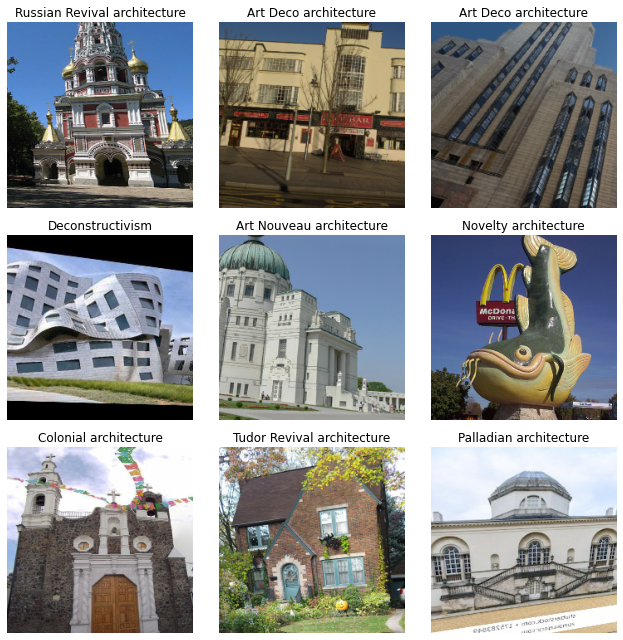

In [116]:
data.show_batch(rows=3, figsize=(9, 9))


In [117]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Achaemenid architecture',
  'American Foursquare architecture',
  'American craftsman style',
  'Ancient Egyptian architecture',
  'Art Deco architecture',
  'Art Nouveau architecture',
  'Baroque architecture',
  'Bauhaus architecture',
  'Beaux-Arts architecture',
  'Byzantine architecture',
  'Chicago school architecture',
  'Colonial architecture',
  'Deconstructivism',
  'Edwardian architecture',
  'Georgian architecture',
  'Gothic architecture',
  'Greek Revival architecture',
  'International style',
  'Novelty architecture',
  'Palladian architecture',
  'Postmodern architecture',
  'Queen Anne architecture',
  'Romanesque architecture',
  'Russian Revival architecture',
  'Tudor Revival architecture'],
 25,
 8091,
 2022)

Data Augmentation

In [118]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

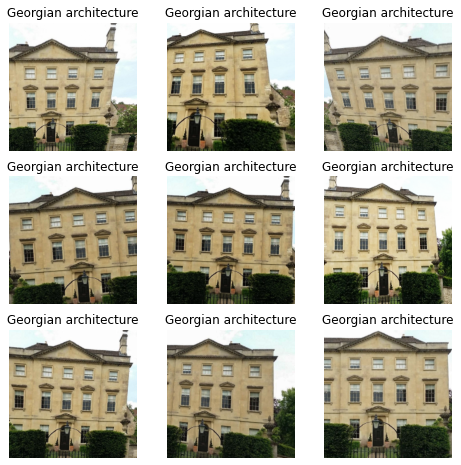

In [119]:
plot_multi(_plot, 3, 3, figsize=(8,8))

Training ResNet50

In [125]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=299, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1).to_fp16()
# there is no impovement with fp16

In [126]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
learn.save('stage-1-resnet50-6cycles')

Fine-tuning and Learning Rates

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-2-resnet50', return_path=True)

Resnet 50 Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))

In [ ]:
learn.show_results(rows=4)

In [ ]:
img = open_image(path/'arcDataset'/'Bauhaus architecture'/'46_800px-Friedrichshafen_Hafenbahnhof_Zeppelinmuseum.jpg')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
data.classes[int(pred_class)]

In [ ]:
outputs